In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from m2bk import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.random.seed(1)
np.set_printoptions(threshold=np.nan)

In [2]:
dataset_handler = DatasetHandler()

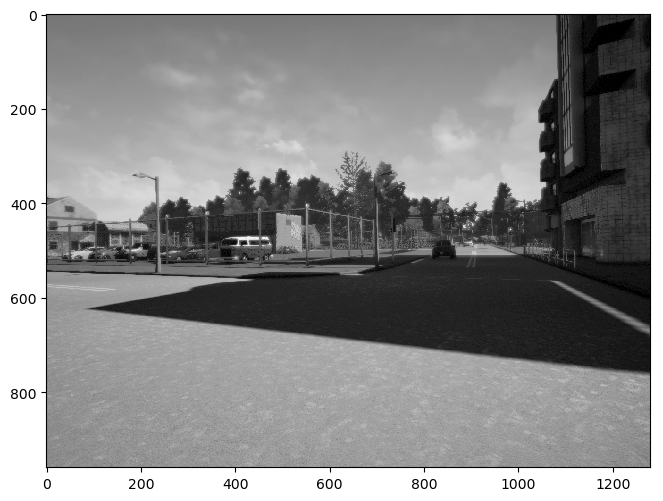

In [3]:
image = dataset_handler.images[0]

plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(image, cmap='gray')

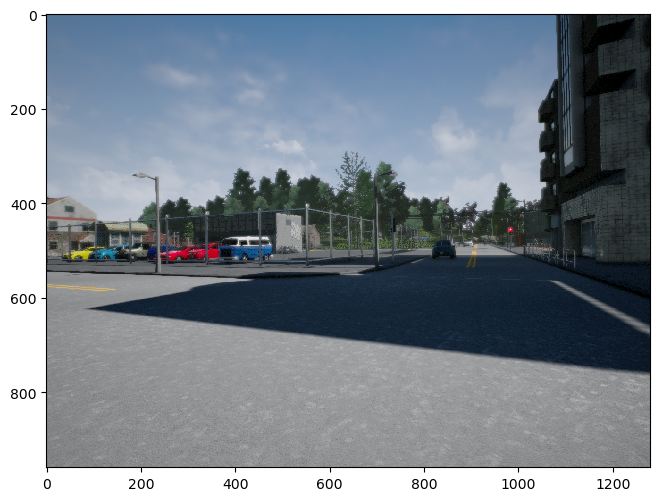

In [4]:
image_rgb = dataset_handler.images_rgb[0]

plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(image_rgb)

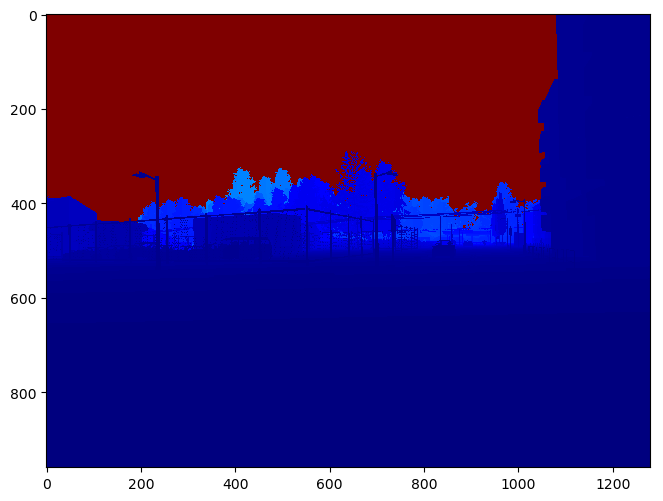

In [5]:
i = 0
depth = dataset_handler.depth_maps[i]

plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(depth, cmap='jet')

In [6]:
print("Depth map shape: {0}".format(depth.shape))

v, u = depth.shape
depth_val = depth[v-1, u-1]
print("Depth value of the very bottom-right pixel of depth map {0} is {1:0.3f}".format(i, depth_val))

Depth map shape: (960, 1280)
Depth value of the very bottom-right pixel of depth map 0 is 1.862


In [7]:
dataset_handler.k

array([[640.,   0., 640.],
       [  0., 480., 480.],
       [  0.,   0.,   1.]], dtype=float32)

In order to access an arbitrary frame use image index, as shown in the examples below. Make sure the indexes are within the number of frames in the dataset. The number of frames in the dataset can be accessed with num_frames attribute.

In [8]:
print(dataset_handler.num_frames)

52


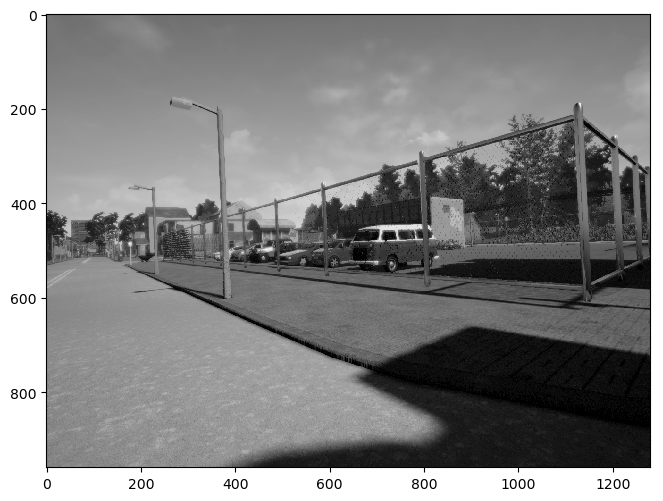

In [9]:
i = 30
image = dataset_handler.images[i]

plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(image, cmap='gray')

In [11]:
def extract_features(image):
    """
    Find keypoints and descriptors for the image

    Arguments:
    image -- a grayscale image

    Returns:
    kp -- list of the extracted keypoints (features) in an image
    des -- list of the keypoint descriptors in an image
    """
    orb = cv2.ORB_create(nfeatures=1500)
    
    kp, des = orb.detectAndCompute(image, None)
    
    return kp, des

In [12]:
i = 0
image = dataset_handler.images[i]
kp, des = extract_features(image)
print("Number of features detected in frame {0}: {1}\n".format(i, len(kp)))

print("Coordinates of the first keypoint in frame {0}: {1}".format(i, str(kp[0].pt)))

Number of features detected in frame 0: 1500

Coordinates of the first keypoint in frame 0: (1004.0, 408.0)


In [13]:
def visualize_features(image, kp):
    """
    Visualize extracted features in the image

    Arguments:
    image -- a grayscale image
    kp -- list of the extracted keypoints

    Returns:
    """
    display = cv2.drawKeypoints(image, kp, None)
    plt.figure(figsize=(16, 12), dpi=100)
    plt.imshow(display)

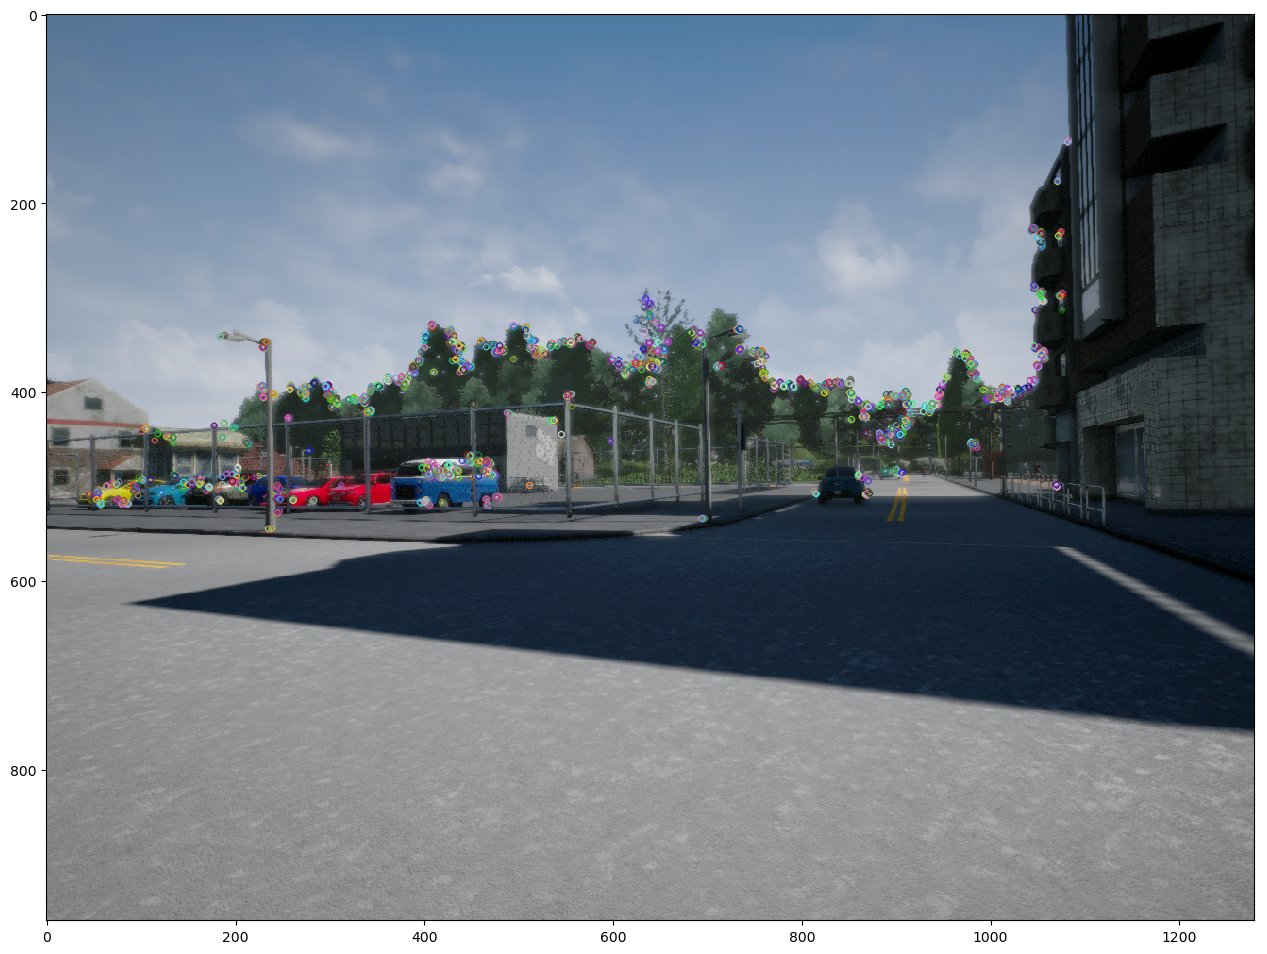

In [14]:
i = 0
image = dataset_handler.images_rgb[i]

visualize_features(image, kp)

In [15]:
def extract_features_dataset(images, extract_features_function):
    """
    Find keypoints and descriptors for each image in the dataset

    Arguments:
    images -- a list of grayscale images
    extract_features_function -- a function which finds features (keypoints and descriptors) for an image

    Returns:
    kp_list -- a list of keypoints for each image in images
    des_list -- a list of descriptors for each image in images
    
    """
    kp_list = [extract_features_function(i)[0] for i in images]
    des_list = [extract_features_function(i)[1] for i in images]

    return kp_list, des_list

In [16]:
images = dataset_handler.images
kp_list, des_list = extract_features_dataset(images, extract_features)

i = 0
print("Number of features detected in frame {0}: {1}".format(i, len(kp_list[i])))
print("Coordinates of the first keypoint in frame {0}: {1}\n".format(i, str(kp_list[i][0].pt)))

print("Length of images array: {0}".format(len(images)))

Number of features detected in frame 0: 1500
Coordinates of the first keypoint in frame 0: (1004.0, 408.0)

Length of images array: 52


In [17]:
def match_features(des1, des2):
    """
    Match features from two images

    Arguments:
    des1 -- list of the keypoint descriptors in the first image
    des2 -- list of the keypoint descriptors in the second image

    Returns:
    match -- list of matched features from two images. Each match[i] is k or less matches for the same query descriptor
    """
    FLANN_INDEX_LSH = 6
    index_params = dict(algorithm = FLANN_INDEX_LSH,
                        table_number = 6,
                        key_size = 12,
                        multi_probe_level = 1)
    search_params = dict(checks = 50)
    
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    
    match = flann.knnMatch(des1, des2, k=2)
    
    return match

In [18]:
i = 0 
des1 = des_list[i]
des2 = des_list[i+1]

match = match_features(des1, des2)
print("Number of features matched in frames {0} and {1}: {2}".format(i, i+1, len(match)))
print(match[0])

Number of features matched in frames 0 and 1: 1500
[<DMatch 0x7f841156a150>, <DMatch 0x7f8411363970>]


In [19]:
def filter_matches_distance(match, dist_threshold):
    """
    Filter matched features from two images by distance between the best matches

    Arguments:
    match -- list of matched features from two images
    dist_threshold -- maximum allowed relative distance between the best matches, (0.0, 1.0) 

    Returns:
    filtered_match -- list of good matches, satisfying the distance threshold
    """
    filtered_match = [i for i, k in match if i.distance < (dist_threshold * k.distance)]

    return filtered_match

In [20]:
i = 0 
des1 = des_list[i]
des2 = des_list[i+1]
match = match_features(des1, des2)

dist_threshold = 0.6
filtered_match = filter_matches_distance(match, dist_threshold)

print("Number of features matched in frames {0} and {1} after filtering by distance: {2}".format(i, i+1, len(filtered_match)))

Number of features matched in frames 0 and 1 after filtering by distance: 582


In [21]:
def visualize_matches(image1, kp1, image2, kp2, match):
    """
    Visualize corresponding matches in two images

    Arguments:
    image1 -- the first image in a matched image pair
    kp1 -- list of the keypoints in the first image
    image2 -- the second image in a matched image pair
    kp2 -- list of the keypoints in the second image
    match -- list of matched features from the pair of images

    Returns:
    image_matches -- an image showing the corresponding matches on both image1 and image2 or None if you don't use this function
    """
    image_matches = cv2.drawMatches(image1,kp1,image2,kp2,match,None)
    plt.figure(figsize=(16, 6), dpi=100)
    plt.imshow(image_matches)

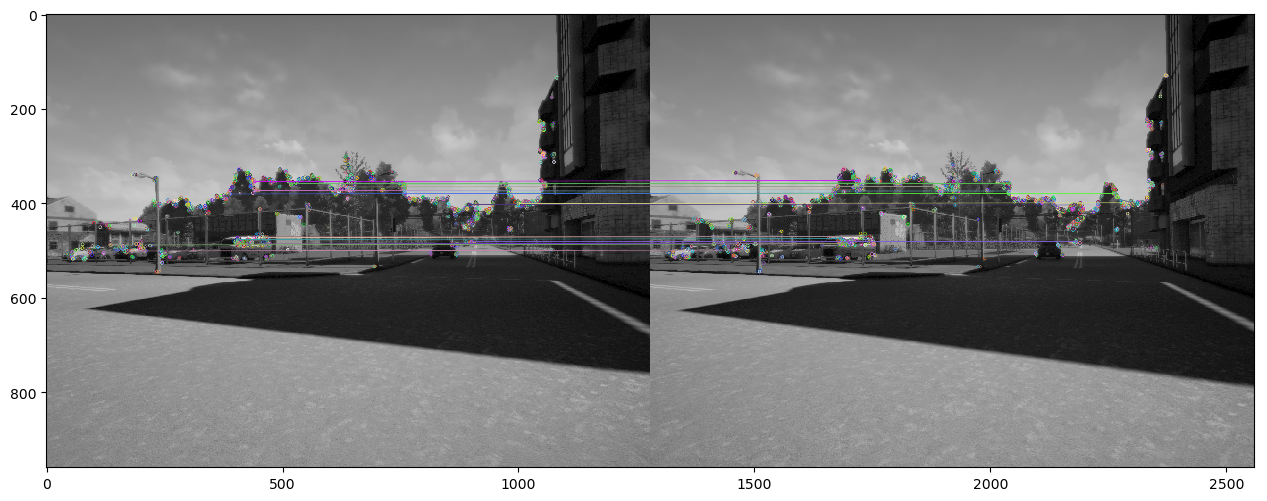

In [22]:
n = 20
filtering = True

i = 0 
image1 = dataset_handler.images[i]
image2 = dataset_handler.images[i+1]

kp1 = kp_list[i]
kp2 = kp_list[i+1]

des1 = des_list[i]
des2 = des_list[i+1]

match = match_features(des1, des2)
if filtering:
    dist_threshold = 0.6
    match = filter_matches_distance(match, dist_threshold)

image_matches = visualize_matches(image1, kp1, image2, kp2, match[:n]) 

In [59]:
def match_features_dataset(des_list, match_features):
    """
    Match features for each subsequent image pair in the dataset

    Arguments:
    des_list -- a list of descriptors for each image in the dataset
    match_features -- a function which maches features between a pair of images

    Returns:
    matches -- list of matches for each subsequent image pair in the dataset. 
               Each matches[i] is a list of matched features from images i and i + 1
               
    """
    matches = [match_features(des_list[i], des_list[i + 1]) for i in range((len(des_list) - 1))]

    return matches

In [60]:
matches = match_features_dataset(des_list, match_features)

i = 0
print("Number of features matched in frames {0} and {1}: {2}".format(i, i+1, len(matches[i])))

Number of features matched in frames 0 and 1: 1500


In [61]:
def filter_matches_dataset(filter_matches_distance, matches, dist_threshold):
    """
    Filter matched features by distance for each subsequent image pair in the dataset

    Arguments:
    filter_matches_distance -- a function which filters matched features from two images by distance between the best matches
    matches -- list of matches for each subsequent image pair in the dataset. 
               Each matches[i] is a list of matched features from images i and i + 1
    dist_threshold -- maximum allowed relative distance between the best matches, (0.0, 1.0) 

    Returns:
    filtered_matches -- list of good matches for each subsequent image pair in the dataset. 
                        Each matches[i] is a list of good matches, satisfying the distance threshold
               
    """
    filtered_matches = [filter_matches_distance(i, dist_threshold) for i in matches]

    return filtered_matches

In [62]:
dist_threshold = 0.6

filtered_matches = filter_matches_dataset(filter_matches_distance, matches, dist_threshold)


if len(filtered_matches) > 0:
    is_main_filtered_m = True
    if is_main_filtered_m: 
        matches = filtered_matches

    i = 0
    print("Number of filtered matches in frames {0} and {1}: {2}".format(i, i+1, len(filtered_matches[i])))

Number of filtered matches in frames 0 and 1: 580


In [63]:
def estimate_motion(match, kp1, kp2, k, depth1=None):
    """
    Estimate camera motion from a pair of subsequent image frames

    Arguments:
    match -- list of matched features from the pair of images
    kp1 -- list of the keypoints in the first image
    kp2 -- list of the keypoints in the second image
    k -- camera calibration matrix 
    
    Optional arguments:
    depth1 -- a depth map of the first frame. This argument is not needed if you use Essential Matrix Decomposition

    Returns:
    rmat -- recovered 3x3 rotation numpy matrix
    tvec -- recovered 3x1 translation numpy vector
    image1_points -- a list of selected match coordinates in the first image. image1_points[i] = [u, v], where u and v are 
                     coordinates of the i-th match in the image coordinate system
    image2_points -- a list of selected match coordinates in the second image. image1_points[i] = [u, v], where u and v are 
                     coordinates of the i-th match in the image coordinate system
               
    """
    rmat = np.eye(3)
    tvec = np.zeros((3, 1))
    image1_points = []
    image2_points = []
    objectpoints = []
    
    for i in match:

        u1, v1 = kp1[i.queryIdx].pt
        u2, v2 = kp2[i.trainIdx].pt
        
        s = depth1[int(v1), int(u1)]
        
        if s < 1000:

            p_c = np.linalg.inv(k) @ (s * np.array([u1, v1, 1]))
            
            image1_points.append([u1, v1])
            image2_points.append([u2, v2])
            objectpoints.append(p_c)
    
    objectpoints = np.array(objectpoints)
    imagepoints = np.array(image2_points)
    
    _, rvec, tvec, _ = cv2.solvePnPRansac(objectpoints, imagepoints, k, None)
    
    rmat, _ = cv2.Rodrigues(rvec)
    
    return rmat, tvec, image1_points, image2_points

In [64]:
i = 0
match = matches[i]
kp1 = kp_list[i]
kp2 = kp_list[i+1]
k = dataset_handler.k
depth = dataset_handler.depth_maps[i]

rmat, tvec, image1_points, image2_points = estimate_motion(match, kp1, kp2, k, depth1=depth)

print("Estimated rotation:\n {0}".format(rmat))
print("Estimated translation:\n {0}".format(tvec))

Estimated rotation:
 [[ 9.99983879e-01 -5.58330315e-03  1.03371872e-03]
 [ 5.58392369e-03  9.99984231e-01 -5.98387287e-04]
 [-1.03036144e-03  6.04149847e-04  9.99999287e-01]]
Estimated translation:
 [[ 0.01097534]
 [-0.0004655 ]
 [-0.30594603]]


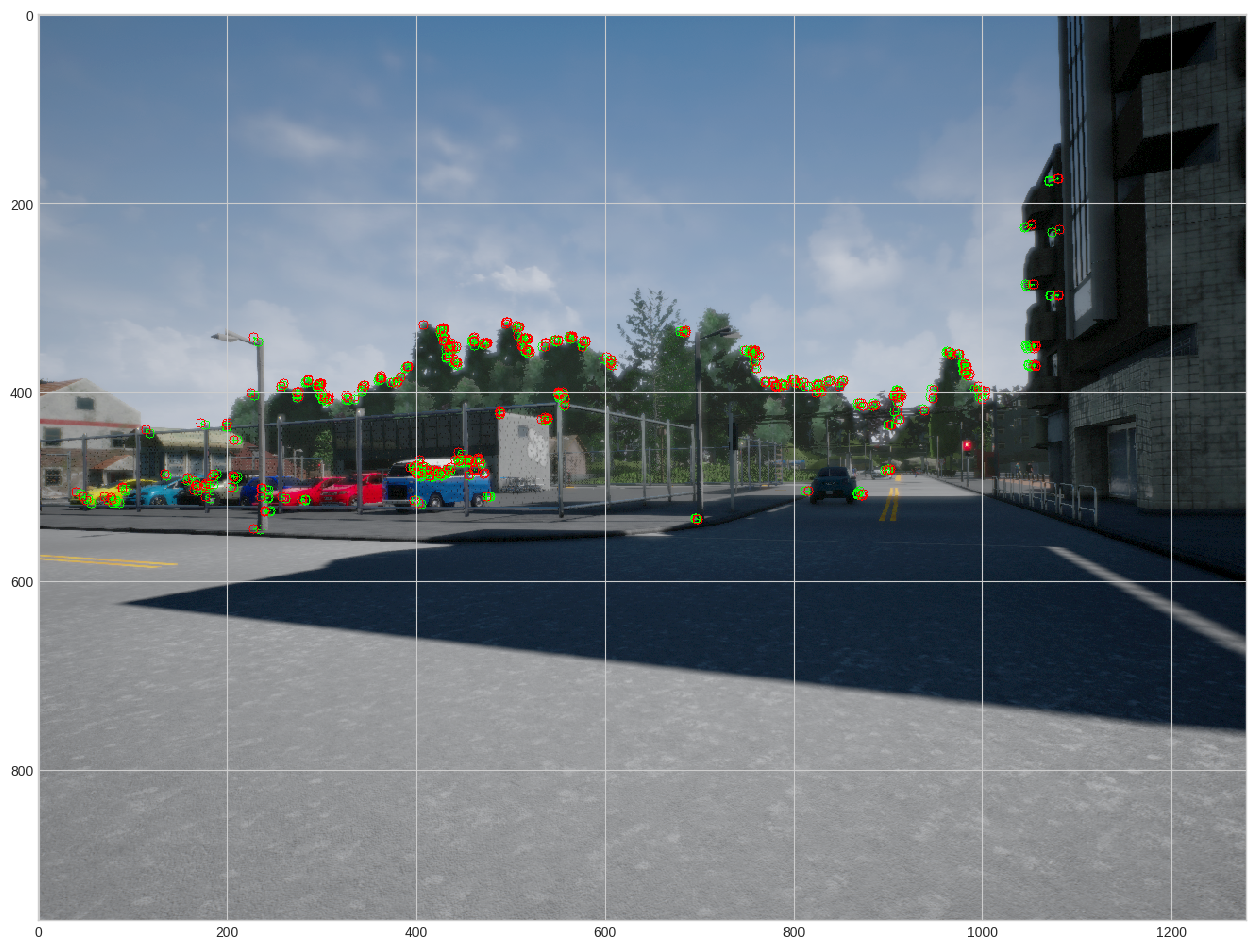

In [65]:
i=0
image1  = dataset_handler.images_rgb[i]
image2 = dataset_handler.images_rgb[i + 1]

image_move = visualize_camera_movement(image1, image1_points, image2, image2_points)
plt.figure(figsize=(16, 12), dpi=100)
plt.imshow(image_move)

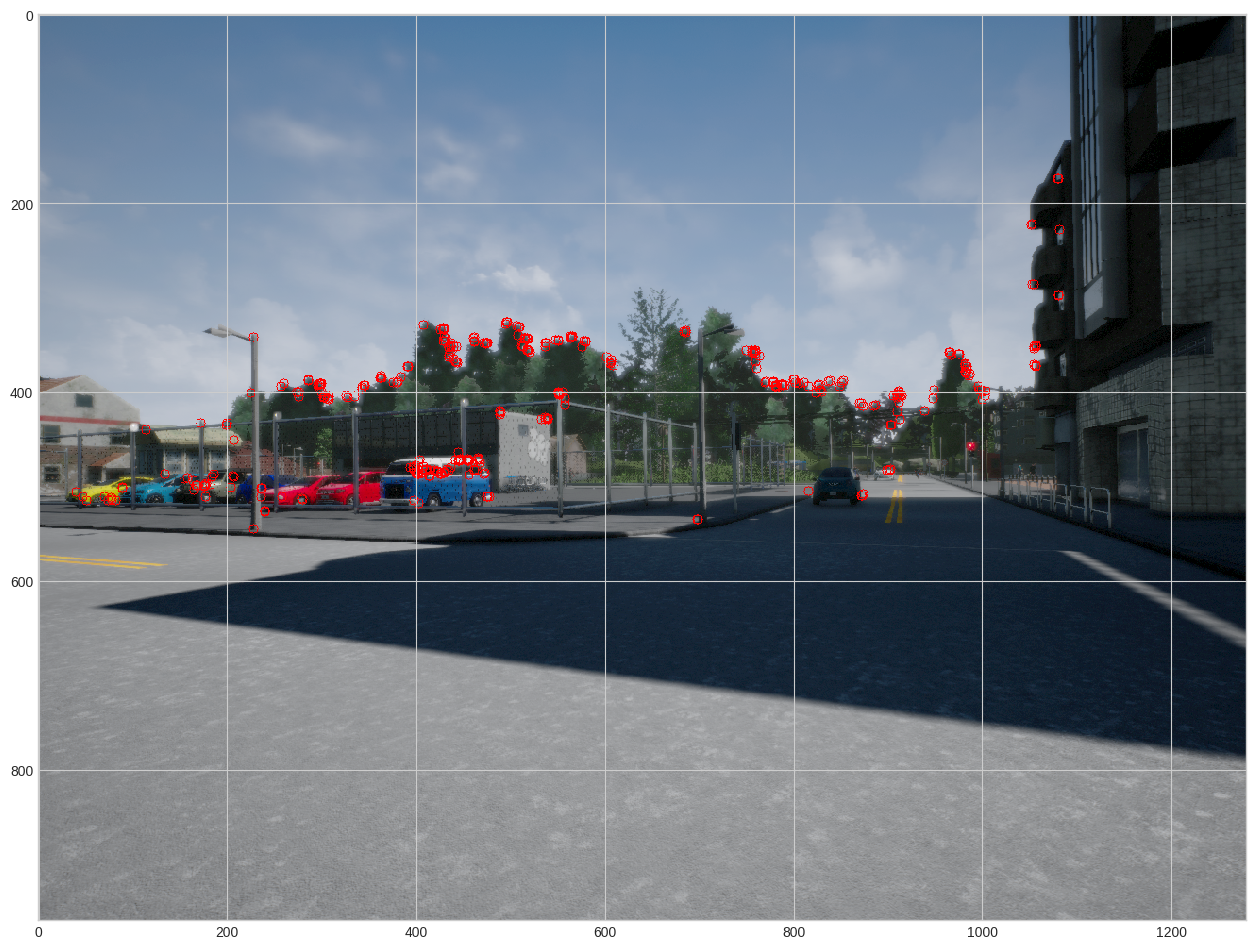

In [66]:
image_move = visualize_camera_movement(image1, image1_points, image2, image2_points, is_show_img_after_move=True)
plt.figure(figsize=(16, 12), dpi=100)
plt.imshow(image_move)

In [67]:
def estimate_trajectory(estimate_motion, matches, kp_list, k, depth_maps=[],save=''):
    """
    Estimate complete camera trajectory from subsequent image pairs

    Arguments:
    estimate_motion -- a function which estimates camera motion from a pair of subsequent image frames
    matches -- list of matches for each subsequent image pair in the dataset. 
               Each matches[i] is a list of matched features from images i and i + 1
    des_list -- a list of keypoints for each image in the dataset
    k -- camera calibration matrix 
    
    Optional arguments:
    depth_maps -- a list of depth maps for each frame. This argument is not needed if you use Essential Matrix Decomposition

    Returns:
    trajectory -- a 3xlen numpy array of the camera locations, where len is the lenght of the list of images and   
                  trajectory[:, i] is a 3x1 numpy vector, such as:
                  
                  trajectory[:, i][0] - is X coordinate of the i-th location
                  trajectory[:, i][1] - is Y coordinate of the i-th location
                  trajectory[:, i][2] - is Z coordinate of the i-th location
                  
                  * Consider that the origin of your trajectory cordinate system is located at the camera position 
                  when the first image (the one with index 0) was taken. The first camera location (index = 0) is geven 
                  at the initialization of this function

    """
    T_old = np.eye(4)
    trajectory = np.zeros((3,len(matches)+1))

    for i in range(len(matches)):
        rmat, tvec, image1_points, image2_points = estimate_motion(matches[i], kp_list[i], kp_list[i+1], k, depth_maps[i])
        T_new = np.eye(4)
        T_new[:3,:3] = rmat
        T_new[:3, 3] = tvec.T
        T_old = T_old @ np.linalg.inv(T_new)
        trajectory[:,i+1] = (T_old @ np.array([0.,0.,0.,1.]))[:3]
    
    return trajectory

In [68]:
depth_maps = dataset_handler.depth_maps
trajectory = estimate_trajectory(estimate_motion, matches, kp_list, k, depth_maps=depth_maps)

i = 1
print("Camera location in point {0} is: \n {1}\n".format(i, trajectory[:, [i]]))

# Remember that the length of the returned by trajectory should be the same as the length of the image array
print("Length of trajectory: {0}".format(trajectory.shape[1]))

Camera location in point 1 is: 
 [[-0.0112878 ]
 [ 0.00071161]
 [ 0.30593418]]

Length of trajectory: 52


In [70]:
# Part 1. Features Extraction
images = dataset_handler.images
kp_list, des_list = extract_features_dataset(images, extract_features)

# Part II. Feature Matching
matches = match_features_dataset(des_list, match_features)

is_main_filtered_m = True
if is_main_filtered_m:
    dist_threshold = 0.75
    filtered_matches = filter_matches_dataset(filter_matches_distance, matches, dist_threshold)
    matches = filtered_matches

# Part III. Trajectory Estimation
depth_maps = dataset_handler.depth_maps
trajectory = estimate_trajectory(estimate_motion, matches, kp_list, k, depth_maps=depth_maps)


print("Trajectory X:\n {0}".format(trajectory[0,:].reshape((1,-1))))
print("Trajectory Y:\n {0}".format(trajectory[1,:].reshape((1,-1))))
print("Trajectory Z:\n {0}".format(trajectory[2,:].reshape((1,-1))))

Trajectory X:
 [[  0.          -7.00118198  -7.00374274  -7.00761381  -6.99726232
   -7.00668035  -7.0293782   -7.05364919  -7.09260849  -7.11329276
   -7.13751883  -7.16674431  -7.21528291  -7.28937899  -7.40630031
   -7.60498453  -7.74090624  -7.88858585  -8.02598017  -8.13364938
   -8.25849976  -8.4034541   -8.58278989  -8.82262753  -9.02744923
   -9.23232495  -9.42204997  -9.58282477  -9.7756635   -9.96925133
  -10.2059363  -10.44327167 -10.74217292 -11.07168466 -11.42945751
  -11.80966408 -12.20726775 -12.64562555 -13.06853653 -13.49903884
  -13.93476355 -14.36409793 -14.79006029 -15.20042483 -15.63829586
  -16.06952303 -16.47621526 -16.87525012 -17.26124383 -17.63266276
  -17.98633282 -18.31659773]]
Trajectory Y:
 [[ 0.          1.09089483  1.06278464  1.04299931  1.01261767  0.97998636
   0.93841945  0.90234113  0.8631723   0.82951253  0.79848432  0.75734432
   0.70733359  0.64707585  0.58533978  0.49949516  0.4307878   0.37332819
   0.30415619  0.24861408  0.17789612  0.1144534

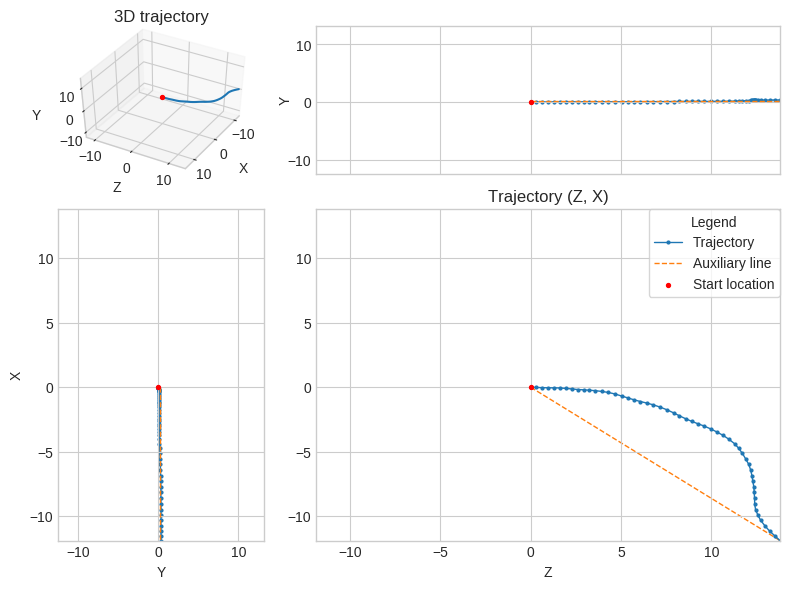

In [69]:
visualize_trajectory(trajectory)